# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Imports

Installing feature engines lag feature to use the lag technique in data preprocessing

In [101]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.2.2 which is incompatible.


In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import layers
from keras import models

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [2]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 64.7MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [3]:
traffic_df = pd.read_csv('Traffic Data.csv')

In [4]:
traffic_df.sample(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
13696,3344.0,266.42,0.0,0.0,90,Snow,light snow,2018-02-19 09:00:00
7110,6691.0,289.14,0.0,0.0,90,Clouds,overcast clouds,2017-08-28 07:00:00
9348,5068.0,293.75,0.0,0.0,90,Clouds,overcast clouds,2017-06-29 13:00:00
5858,5036.0,290.42,0.0,0.0,1,Clear,sky is clear,2017-06-23 09:00:00
18934,6044.0,292.96,0.0,0.0,90,Rain,light rain,2017-06-22 08:00:00
7464,2649.0,267.62,0.0,0.0,1,Clear,sky is clear,2018-03-09 22:00:00
8914,648.0,291.08,0.0,0.0,75,Clouds,broken clouds,2018-07-21 02:00:00
14218,4307.0,302.43,0.0,0.0,5,Clear,sky is clear,2017-06-10 11:00:00
6350,2031.0,288.75,0.0,0.0,40,Clouds,scattered clouds,2017-09-28 22:00:00
16156,NaN,290.43,0.0,0.0,1,Mist,mist,2018-08-18 03:00:00


In [5]:
traffic_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [6]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [24]:
traffic_df['date_time'] = pd.to_datetime(traffic_df['date_time'])

In [28]:
traffic_df.duplicated().sum()

12

In [15]:
traffic_df.sample()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
14425,6359.0,297.75,0.0,0.0,75,Clouds,broken clouds,2017-07-24 16:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [11]:
traffic_df['date_time'].unique()

array(['2017-08-27 01:00:00', '2018-09-06 23:00:00',
       '2017-08-25 18:00:00', ..., '2018-03-28 23:00:00',
       '2018-02-12 15:00:00', '2018-05-31 18:00:00'], dtype=object)

Text(0, 0.5, 'Traffic Volume')

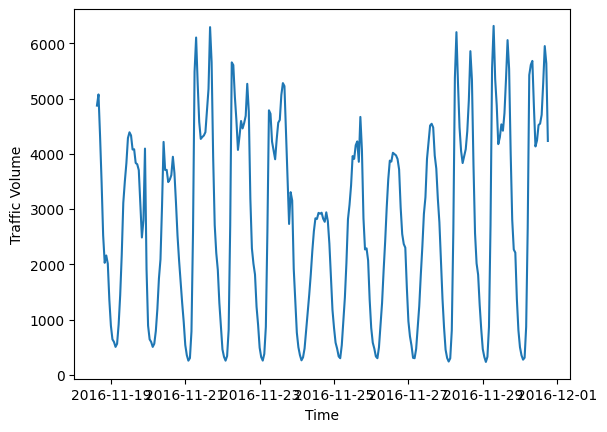

In [98]:
# This is figure 1
plt.plot(traffic_df['date_time'].head(500), traffic_df['traffic_volume'].head(500))
plt.xlabel('Time')
plt.ylabel('Traffic Volume')

In [64]:
# Handelling null values in order to use the seasonal_decompose function
traffic_df = traffic_df.bfill()
traffic_df = traffic_df.dropna()

In [71]:
# Handelling duplicates to sort the date_time column
traffic_df = traffic_df.drop_duplicates()

In [86]:
traffic_df = traffic_df.sort_values(by=['date_time'], ascending=True)

In [87]:
traffic_df.head(20)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00
18985,5074.0,273.84,0.0,0.0,90,Snow,heavy snow,2016-11-18 16:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00
14066,4328.0,273.62,0.0,0.0,90,Snow,heavy snow,2016-11-18 17:00:00
6235,4328.0,273.62,0.0,0.0,90,Mist,mist,2016-11-18 17:00:00
8329,4328.0,273.62,0.0,0.0,90,Fog,fog,2016-11-18 17:00:00
7976,3486.0,273.59,0.0,0.0,90,Mist,mist,2016-11-18 18:00:00


In [93]:
date_time_df = traffic_df.groupby('date_time').sum()
date_time_df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,14616.0,822.24,0.0,0.0,270,MistFogSnow,mistfogheavy snow
2016-11-18 16:00:00,15222.0,821.52,0.0,0.0,270,MistSnowFog,mistheavy snowfog
2016-11-18 17:00:00,12984.0,820.86,0.0,0.0,270,SnowMistFog,heavy snowmistfog
2016-11-18 18:00:00,6972.0,547.18,0.0,0.0,180,MistSnow,mistheavy snow
2016-11-18 19:00:00,5048.0,547.16,0.0,0.0,180,MistSnow,mistlight snow


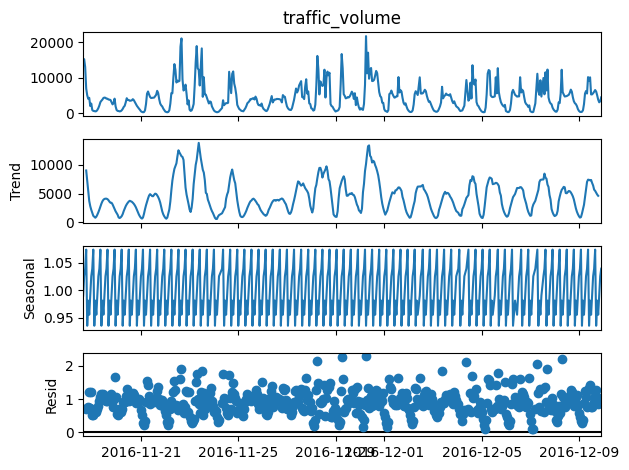

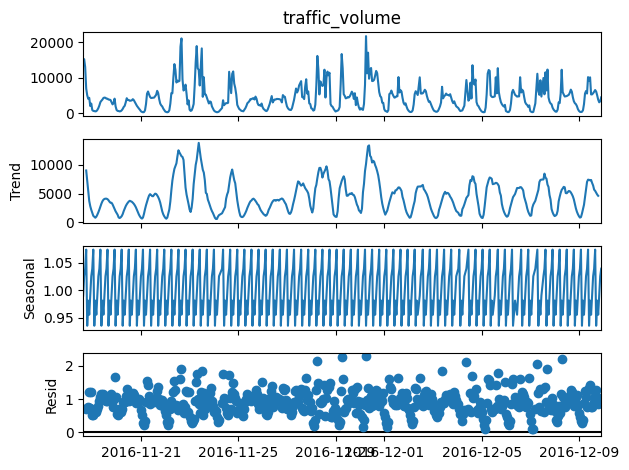

In [177]:
# This is figure 2
seasonal_dec = seasonal_decompose(date_time_df['traffic_volume'].head(500), model='multiplicative', period=7)
seasonal_dec.plot()

In [90]:
# This is figure 3
px.box(traffic_df['traffic_volume'])

In [56]:
# This is figure 4
px.box(traffic_df['temp'])

In [58]:
# This is figure 5
px.box(traffic_df['clouds_all'])

In [59]:
# This is figure 6
px.box(traffic_df['rain_1h'])

In [60]:
# this is figure 7
px.box(traffic_df['snow_1h'])

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [ ]:
# handelling missing values
# traffic_df = traffic_df.bfill()
# traffic_df = traffic_df.dropna()

In [ ]:
# Handelling Duplicates
# traffic_df = traffic_df.drop_duplicates()

In [105]:
# Sorting the dates
# traffic_df = traffic_df.sort_values(by=['date_time'], ascending=True)

In [161]:
lag_f = LagFeatures(periods=1, drop_na=True)
lag_traffic = lag_f.fit_transform(traffic_df)

In [162]:
lag_traffic = lag_traffic.sort_values(by=['date_time'], ascending=True)

In [163]:
lag_traffic.head(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume_lag_1,temp_lag_1,rain_1h_lag_1,snow_1h_lag_1,clouds_all_lag_1
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00,3403.0,271.41,0.00,0.0,90.0
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00,3253.0,294.52,0.00,0.0,90.0
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00,6038.0,286.79,0.00,0.0,90.0
18985,5074.0,273.84,0.0,0.0,90,Snow,heavy snow,2016-11-18 16:00:00,775.0,260.08,0.00,0.0,90.0
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00,2453.0,288.55,0.00,0.0,1.0
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00,3071.0,295.82,1.78,0.0,20.0
14066,4328.0,273.62,0.0,0.0,90,Snow,heavy snow,2016-11-18 17:00:00,234.0,290.57,1.52,0.0,90.0
6235,4328.0,273.62,0.0,0.0,90,Mist,mist,2016-11-18 17:00:00,4570.0,303.22,0.00,0.0,40.0
8329,4328.0,273.62,0.0,0.0,90,Fog,fog,2016-11-18 17:00:00,4879.0,290.58,0.00,0.0,75.0
2646,3486.0,273.59,0.0,0.0,90,Snow,heavy snow,2016-11-18 18:00:00,4689.0,296.32,0.00,0.0,40.0


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [164]:
lag_traffic = lag_traffic.drop(['traffic_volume_lag_1'], axis=1)

In [165]:
lag_traffic['prev_traffic_volume'] = lag_traffic['traffic_volume'].shift(periods=-1, fill_value=0)

In [166]:
lag_traffic['sub_traffic_volume'] = lag_traffic['prev_traffic_volume'] - lag_traffic['traffic_volume']

In [167]:
lag_traffic['day_of_week'] = lag_traffic['date_time'].dt.weekday

In [168]:
lag_traffic['month'] = lag_traffic['date_time'].dt.month

In [169]:
lag_traffic['day_of_year'] = lag_traffic['date_time'].dt.day_of_year

In [170]:
lag_traffic.head(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,temp_lag_1,rain_1h_lag_1,snow_1h_lag_1,clouds_all_lag_1,prev_traffic_volume,sub_traffic_volume,day_of_week,month,day_of_year
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00,271.41,0.00,0.0,90.0,4872.0,0.0,4,11,323
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00,294.52,0.00,0.0,90.0,4872.0,0.0,4,11,323
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00,286.79,0.00,0.0,90.0,5074.0,202.0,4,11,323
18985,5074.0,273.84,0.0,0.0,90,Snow,heavy snow,2016-11-18 16:00:00,260.08,0.00,0.0,90.0,5074.0,0.0,4,11,323
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00,288.55,0.00,0.0,1.0,5074.0,0.0,4,11,323
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00,295.82,1.78,0.0,20.0,4328.0,-746.0,4,11,323
14066,4328.0,273.62,0.0,0.0,90,Snow,heavy snow,2016-11-18 17:00:00,290.57,1.52,0.0,90.0,4328.0,0.0,4,11,323
6235,4328.0,273.62,0.0,0.0,90,Mist,mist,2016-11-18 17:00:00,303.22,0.00,0.0,40.0,4328.0,0.0,4,11,323
8329,4328.0,273.62,0.0,0.0,90,Fog,fog,2016-11-18 17:00:00,290.58,0.00,0.0,75.0,3486.0,-842.0,4,11,323
2646,3486.0,273.59,0.0,0.0,90,Snow,heavy snow,2016-11-18 18:00:00,296.32,0.00,0.0,40.0,3486.0,0.0,4,11,323


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [138]:
lag_traffic['weather_main'].unique()

array(['Snow', 'Fog', 'Mist', 'Haze', 'Clouds', 'Clear', 'Rain',
       'Drizzle', 'Thunderstorm', 'Smoke'], dtype=object)

In [139]:
lag_traffic['weather_description'].unique()

array(['heavy snow', 'fog', 'mist', 'light snow', 'haze',
       'overcast clouds', 'sky is clear', 'broken clouds',
       'scattered clouds', 'few clouds', 'light rain', 'moderate rain',
       'light intensity drizzle', 'snow', 'freezing rain',
       'shower drizzle', 'drizzle', 'proximity thunderstorm',
       'heavy intensity rain', 'proximity shower rain', 'thunderstorm',
       'light shower snow', 'Sky is Clear', 'sleet',
       'thunderstorm with heavy rain', 'heavy intensity drizzle',
       'light rain and snow', 'thunderstorm with light rain',
       'proximity thunderstorm with rain',
       'thunderstorm with light drizzle',
       'proximity thunderstorm with drizzle',
       'light intensity shower rain', 'thunderstorm with rain', 'smoke'],
      dtype=object)

In [171]:
# Encoding the labels before splitting the dataframe
lag_traffic = lag_traffic.drop('weather_description', axis=1)
labenc = LabelEncoder()
encoded_lag_traffic = labenc.fit_transform(lag_traffic['weather_main'])

In [172]:
encoded_lag_traffic = pd.DataFrame(encoded_lag_traffic, columns=['weather_main'])
lag_traffic = lag_traffic.drop('weather_main', axis=1)
lag_traffic['weather_main'] = encoded_lag_traffic

In [173]:
lag_traffic

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,date_time,temp_lag_1,rain_1h_lag_1,snow_1h_lag_1,clouds_all_lag_1,prev_traffic_volume,sub_traffic_volume,day_of_week,month,day_of_year,weather_main
7745,4872.0,274.08,0.0,0.0,90,2016-11-18 15:00:00,271.41,0.0,0.0,90.0,4872.0,0.0,4,11,323,0.0
4628,4872.0,274.08,0.0,0.0,90,2016-11-18 15:00:00,294.52,0.0,0.0,90.0,4872.0,0.0,4,11,323,1.0
14496,4872.0,274.08,0.0,0.0,90,2016-11-18 15:00:00,286.79,0.0,0.0,90.0,5074.0,202.0,4,11,323,1.0
18985,5074.0,273.84,0.0,0.0,90,2016-11-18 16:00:00,260.08,0.0,0.0,90.0,5074.0,0.0,4,11,323,1.0
8867,5074.0,273.84,0.0,0.0,90,2016-11-18 16:00:00,288.55,0.0,0.0,1.0,5074.0,0.0,4,11,323,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,3543.0,283.45,0.0,0.0,75,2018-09-30 19:00:00,301.94,0.0,0.0,1.0,2781.0,-762.0,6,9,273,1.0
14241,2781.0,282.76,0.0,0.0,90,2018-09-30 20:00:00,269.68,0.0,0.0,40.0,2159.0,-622.0,6,9,273,1.0
9500,2159.0,282.73,0.0,0.0,90,2018-09-30 21:00:00,292.14,0.0,0.0,1.0,1450.0,-709.0,6,9,273,0.0
15201,1450.0,282.09,0.0,0.0,90,2018-09-30 22:00:00,262.95,0.0,0.0,75.0,954.0,-496.0,6,9,273,1.0


In [186]:
lag_traffic = lag_traffic.set_index('date_time')

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,temp_lag_1,rain_1h_lag_1,snow_1h_lag_1,clouds_all_lag_1,prev_traffic_volume,sub_traffic_volume,day_of_week,month,day_of_year,weather_main
date_time,,,,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,271.41,0.0,0.0,90.0,4872.0,0.0,4,11,323,0.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,294.52,0.0,0.0,90.0,4872.0,0.0,4,11,323,1.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,286.79,0.0,0.0,90.0,5074.0,202.0,4,11,323,1.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,260.08,0.0,0.0,90.0,5074.0,0.0,4,11,323,1.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,288.55,0.0,0.0,1.0,5074.0,0.0,4,11,323,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,301.94,0.0,0.0,1.0,2781.0,-762.0,6,9,273,1.0
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,269.68,0.0,0.0,40.0,2159.0,-622.0,6,9,273,1.0
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,292.14,0.0,0.0,1.0,1450.0,-709.0,6,9,273,0.0


In [187]:
train_split = round(len(lag_traffic) * 0.8)

train_data = lag_traffic.iloc[:train_split]
test_data = lag_traffic.iloc[train_split:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [206]:
minmax = MinMaxScaler(feature_range=(0, 1))

scaled_training = minmax.fit_transform(train_data['traffic_volume'].values.reshape(-1, 1))
scaled_testing = minmax.transform(test_data['traffic_volume'].values.reshape(-1, 1))

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
# Model 1 : LSTM
# Model 2 : GRU

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [207]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [208]:
X_train, Y_train = create_dataset(scaled_training, 10)
X_test, Y_test = create_dataset(scaled_testing, 10)

In [209]:
X_train.shape

(15979, 10, 1)

In [210]:
Y_train.shape

(15979,)

In [211]:
X_test.shape

(3986, 10, 1)

In [212]:
model1 = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(10, 1)),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(1)
])

model1.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [213]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [217]:
model1_history = model1.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.4112e-04 - val_loss: 5.8343e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5.9944e-04 - val_loss: 6.0963e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.8419e-04 - val_loss: 5.8303e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.8317e-04 - val_loss: 5.8601e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.5201e-04 - val_loss: 5.8939e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.9926e-04 - val_loss: 5.7664e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.0442e-04 - val_loss: 6.1324e-04
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.0437e-04 - val_loss: 5.9052e-04
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.0395e-04 - val_loss: 5.8638e-04
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.3888e-04 - val_loss: 6.0815e-04
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [216]:
lstm_predictions = model1.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [231]:
lstmtestScore = mean_squared_error(Y_test, lstm_predictions)
print('Test Score: %.2f MSE' % (lstmtestScore))

Test Score: 0.00 MSE


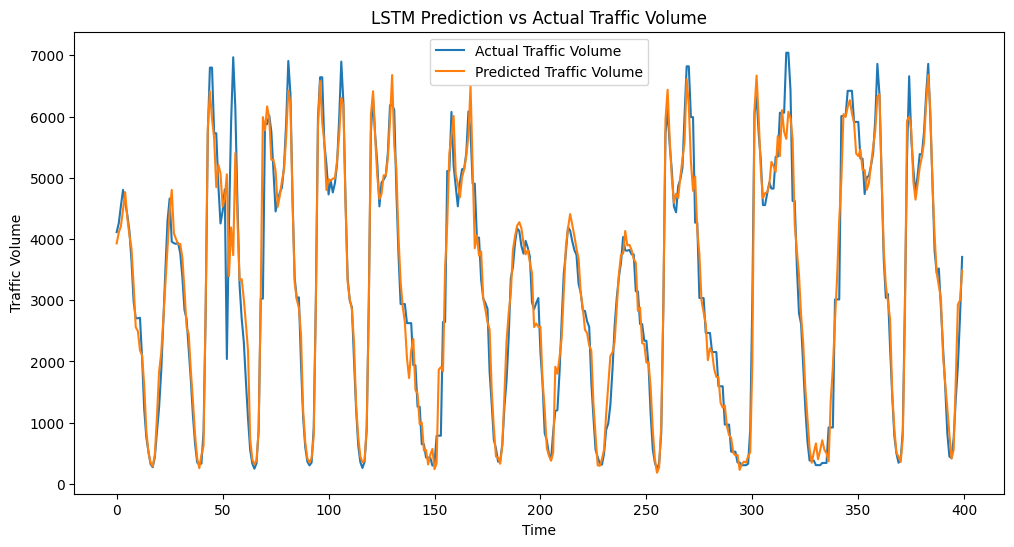

In [244]:
lstm_predictions_rescaled = minmax.inverse_transform(lstm_predictions.reshape(-1, 1))
Y_test_rescaled = minmax.inverse_transform(Y_test.reshape(-1, 1))
plt.figure(figsize=(12,6))
plt.plot(Y_test_rescaled[:400], label='Actual Traffic Volume')
plt.plot(lstm_predictions_rescaled[:400], label='Predicted Traffic Volume')
plt.title('LSTM Prediction vs Actual Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

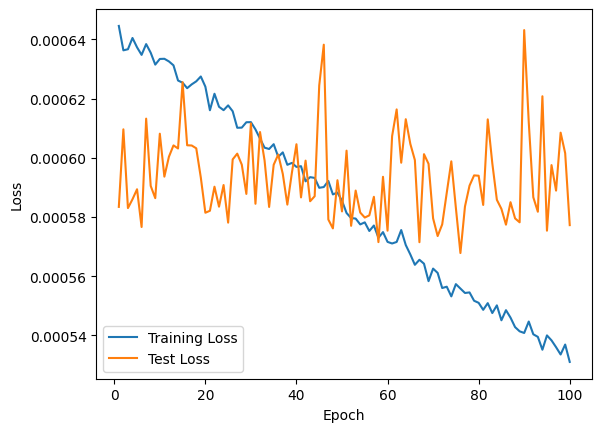

In [232]:
loss = model1_history.history['loss']
val_loss = model1_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [233]:
model2 = models.Sequential([
    layers.GRU(64, return_sequences=True, input_shape=(10, 1)),
    layers.GRU(32, return_sequences=False),
    layers.Dense(1)
])

model2.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [234]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

In [235]:
model2_history = model2.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0073 - val_loss: 0.0015
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0014 - val_loss: 9.7431e-04
Epoch 12/100
250/250 ━━━━━

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [237]:
gru_predictions = model2.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [238]:
gru_test_score = mean_squared_error(Y_test, gru_predictions)
print('Test Score: %.2f MSE' % (gru_test_score))

Test Score: 0.00 MSE


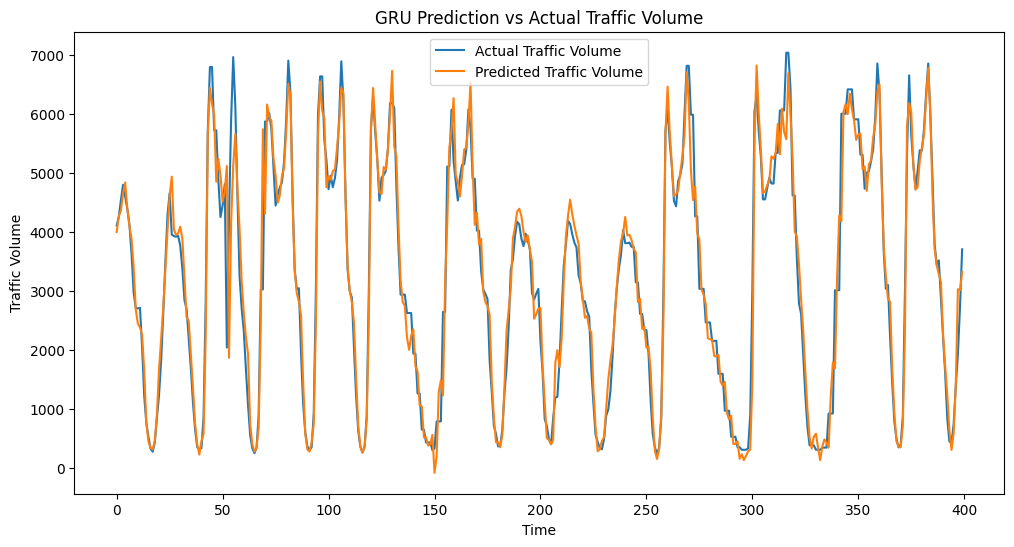

In [242]:
gru_predictions_rescaled = minmax.inverse_transform(gru_predictions.reshape(-1, 1))
plt.figure(figsize=(12,6))
plt.plot(Y_test_rescaled[:400], label='Actual Traffic Volume')
plt.plot(gru_predictions_rescaled[:400], label='Predicted Traffic Volume')
plt.title('GRU Prediction vs Actual Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

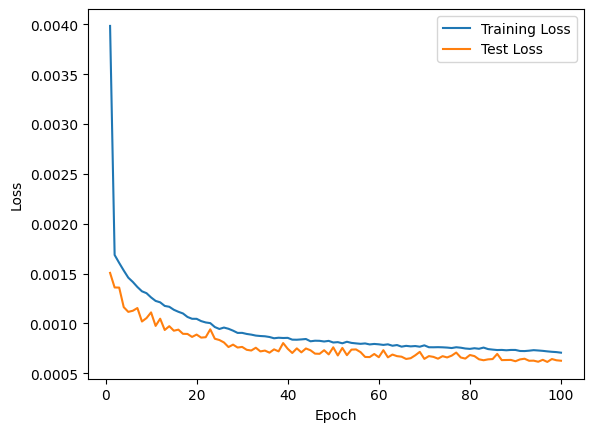

In [240]:
loss1 = model2_history.history['loss']
val_loss1 = model2_history.history['val_loss']
epochs1 = range(1, len(loss1) + 1)
plt.plot(epochs1, loss1, label='Training Loss')
plt.plot(epochs1, val_loss1, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

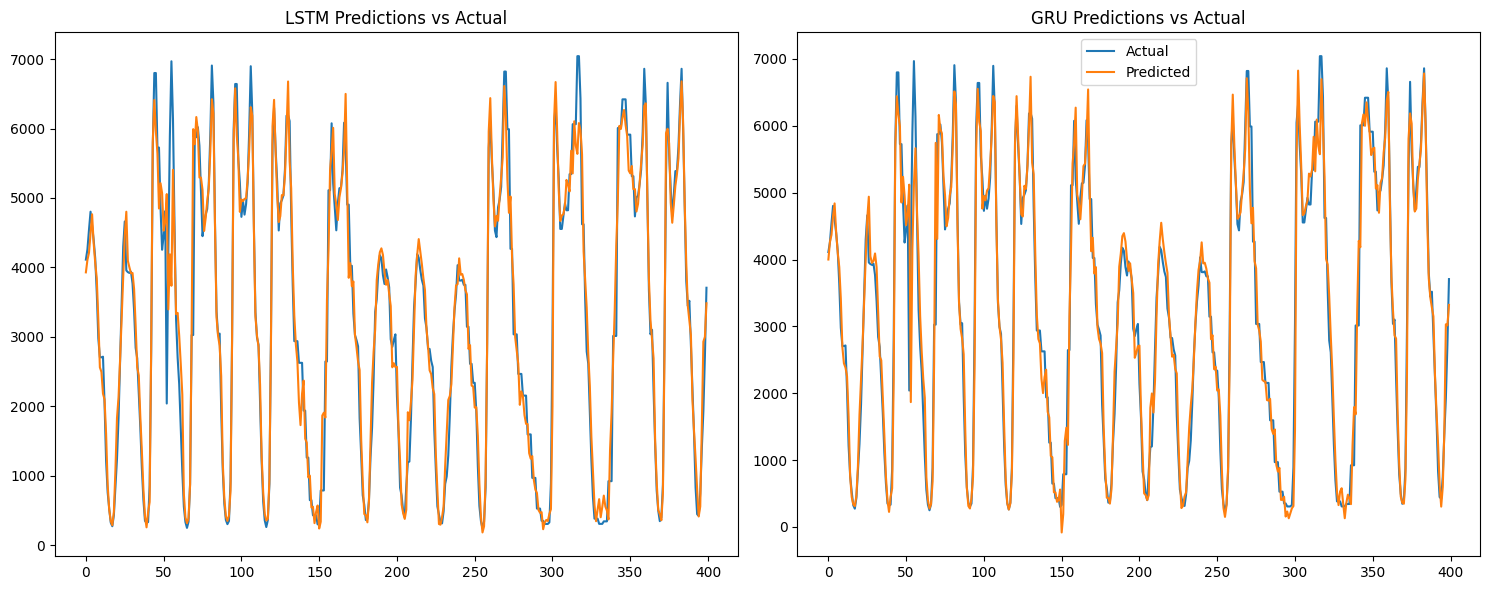

In [250]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(Y_test_rescaled[:400], label='Actual')
plt.plot(lstm_predictions_rescaled[:400], label='Predicted')
plt.title('LSTM Predictions vs Actual')

plt.subplot(1, 2, 2)
plt.plot(Y_test_rescaled[:400], label='Actual')
plt.plot(gru_predictions_rescaled[:400], label='Predicted')
plt.title('GRU Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

In [247]:
lstm_predictions

array([[0.22891134],
       [0.23964426],
       [0.2458665 ],
       ...,
       [0.18946496],
       [0.1421426 ],
       [0.10981346]], dtype=float32)

In [248]:
gru_predictions

array([[0.23319449],
       [0.24900989],
       [0.25531313],
       ...,
       [0.19849087],
       [0.1451466 ],
       [0.10628843]], dtype=float32)

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

Data Preprocessing:
I chose to preprocess the data using the basics learnt techniques such as handelling the missing values removing duplicates handelling inconsistent data to ensure that the data going to the train function is clean and accurate, these help the model provide a more accurate prediction.
Feature Engineering:
I have added the lag for each numerical column to give more insight on the data and calculated the difference between the previous and current traffic volume to get more information on how the trends are shown. transforming the data_time column to a pd.datetime datatype was really important as it allowed me to sort the values of the dates to get a better reading on the data.
Model Architecture:
I chose this specific model architecture because I am only using one feature to predict and having more then the built layers above will provide unnecessary computer usage and may overfit the data.
Training Process:
I chose all the hyper parameters regarding the fitting all randomly and yet they provided an accurate prediction and thus I kept those values
Loss Function and Metrics:
I chose to use Mean squared error as that would provide better use when calculating the range in which the model has mistaken in a smaller numerical form
Model Tuning:
I did not really tune the model many times since my second attempt in training and prediction was very good as the prediction plot was highly accurate
Overfitting and underfitting:
The LSTM model was seen to be overfitting since the epoch and loss graph showed that the validation stayed at a consistent range while the training loss would go lower, and not a lot of overfitting was seen from the GRU model.
Future Improvements:
Handle outliers in a more efficient matter since there was only one column with an uncertain number of outliers rain_1h